##### сеть не удаляет(не блокирует) узел если он перегружен, просто уменьшается нагрузка
##### 
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
   # {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

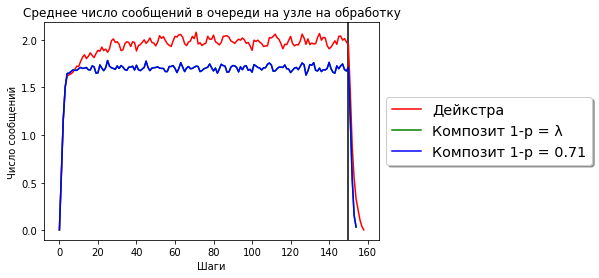

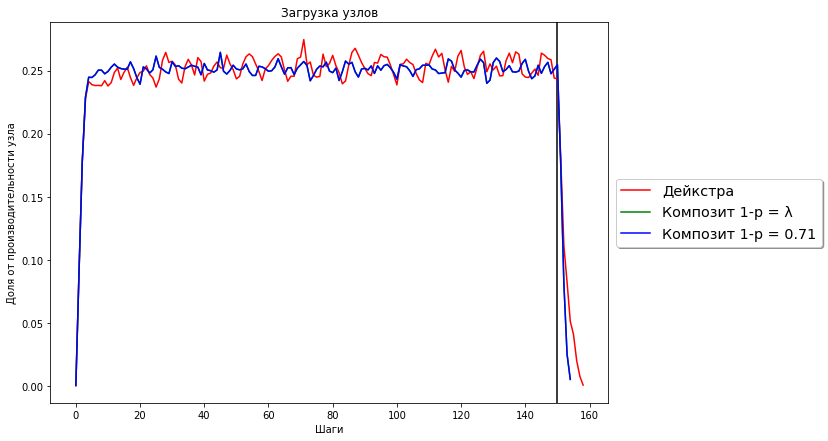

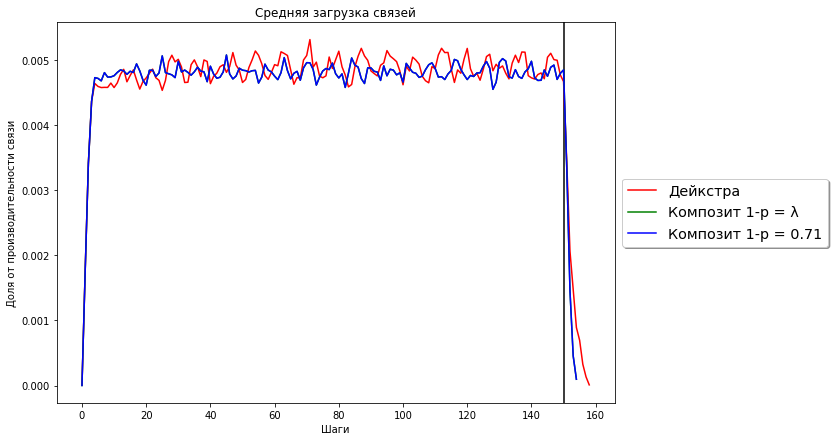

Доставлено 15001 Потеряно 0.0000% -Дейкстра
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = λ
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.71


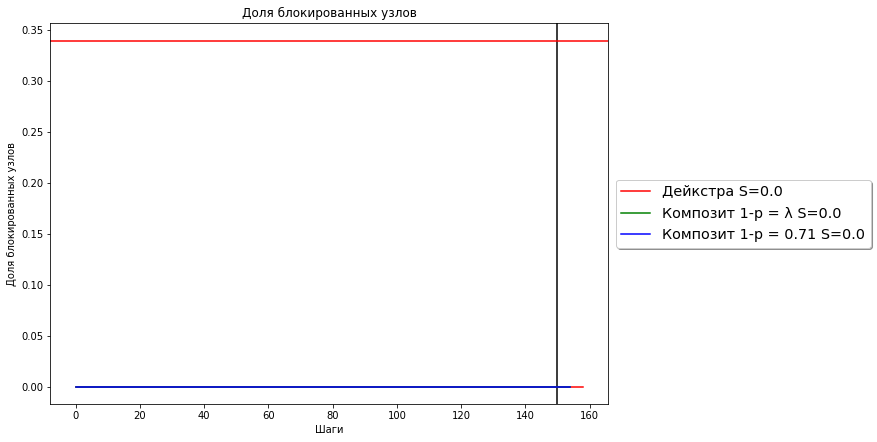

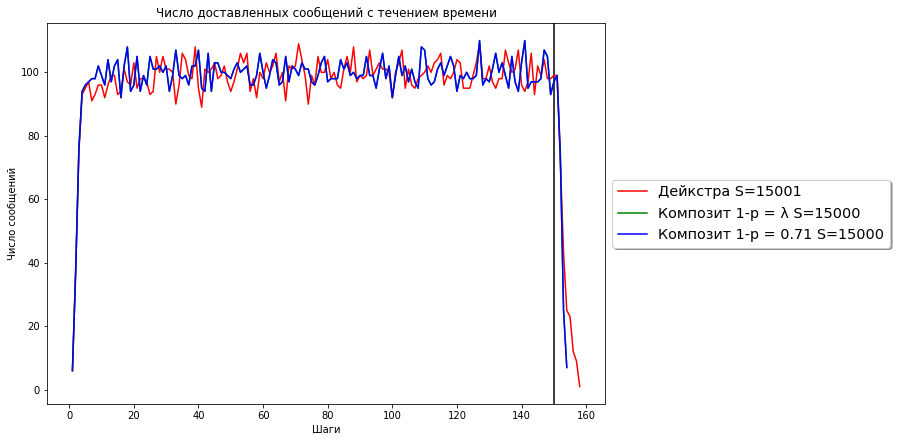

In [2]:
log_tags = [
 {"tag":  "f86975ae-505f-4d97-b7e8-6d6c05d116ee", "label": "Дейкстра", "color": "red"},
# {"tag":  "2b650059-299c-4719-a35e-8e60331d0d22", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "23a61f81-b387-4857-8706-32725f6817ae", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b0e8efc6-059e-4908-aa04-b5da5fe3286c", "label": "Композит 1-p = 0.71", "color": "blue"},
    #  magenta red green black
 
]
quantity = 100; 
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

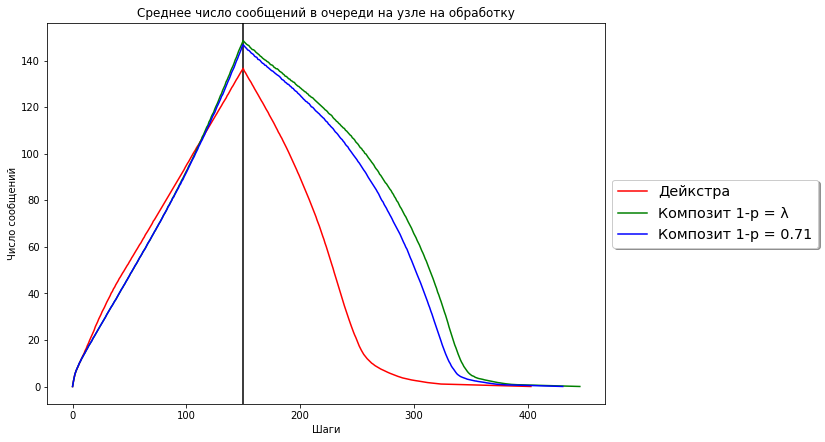

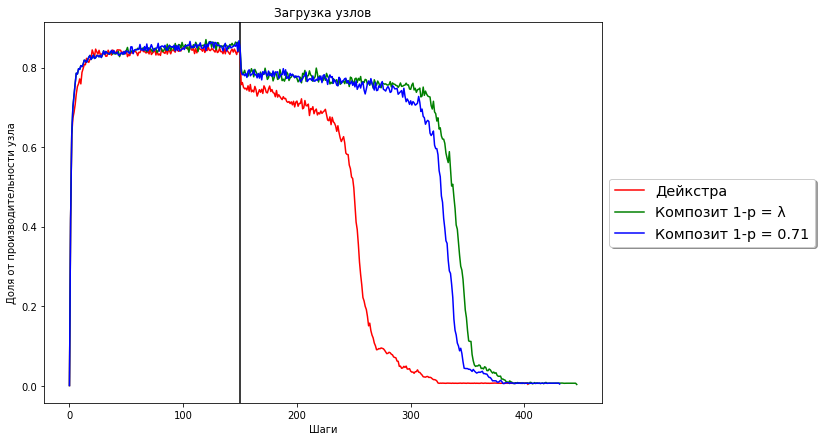

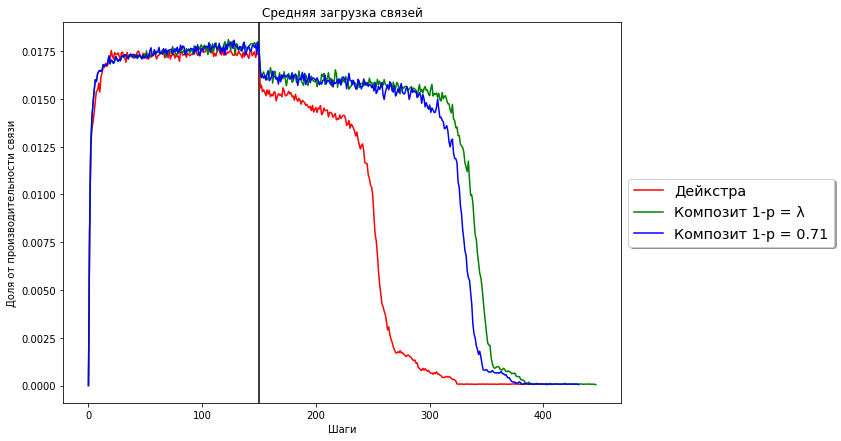

Доставлено 75001 Потеряно 0.0000% -Дейкстра
Доставлено 75000 Потеряно 0.0013% -Композит 1-p = λ
Доставлено 75000 Потеряно 0.0013% -Композит 1-p = 0.71


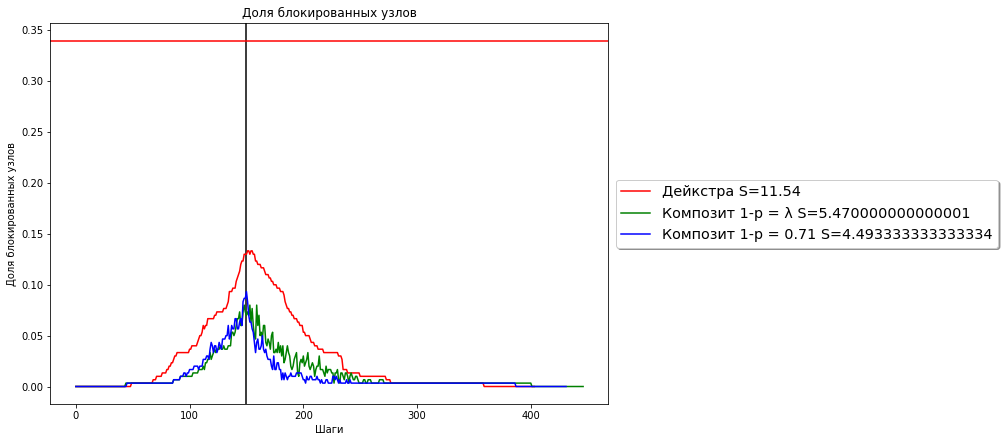

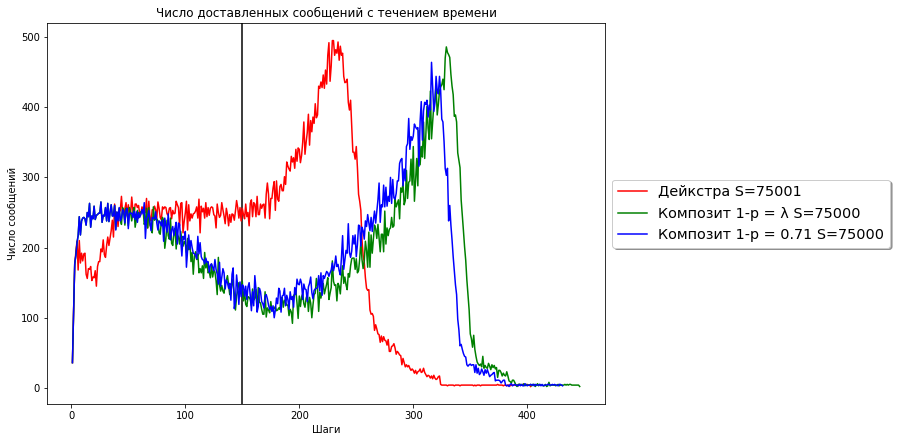

In [3]:
log_tags = [
 {"tag":  "2779ebf1-7964-45fd-a9ef-660dbc79aa38", "label": "Дейкстра", "color": "red"},
 #{"tag":  "07b446ae-f69e-436d-8eb0-5ef918e50bce", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "5541ba46-535c-4e76-922e-85a6fb0a638e", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "fbb58922-4436-4f0c-b1f8-d3f52b9c167b", "label": "Композит 1-p = 0.71", "color": "blue"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

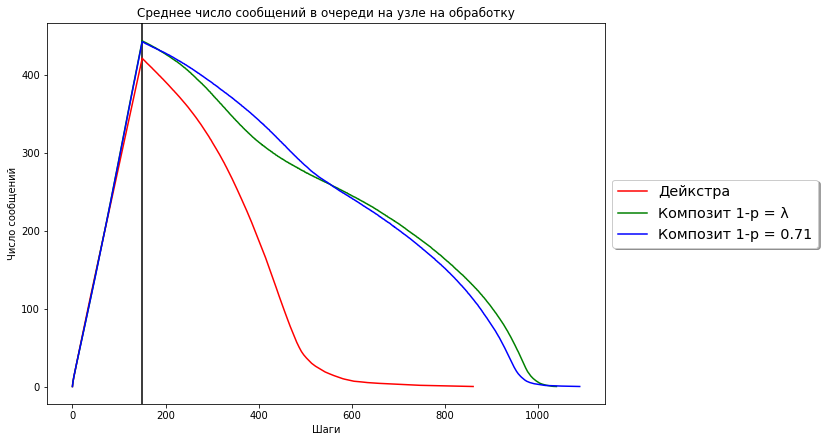

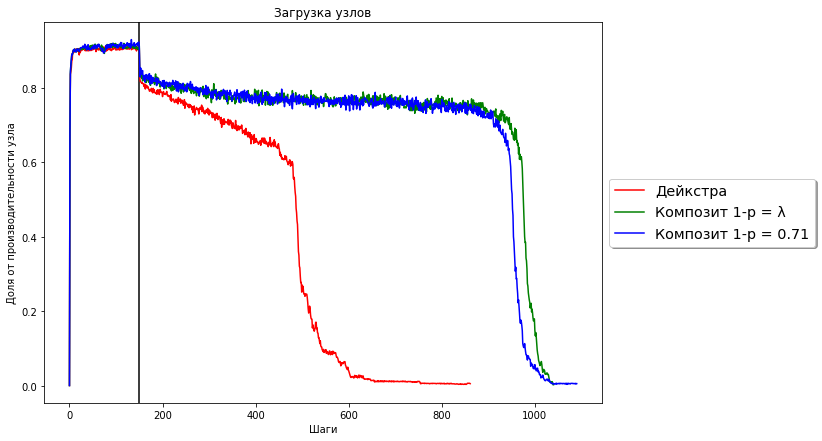

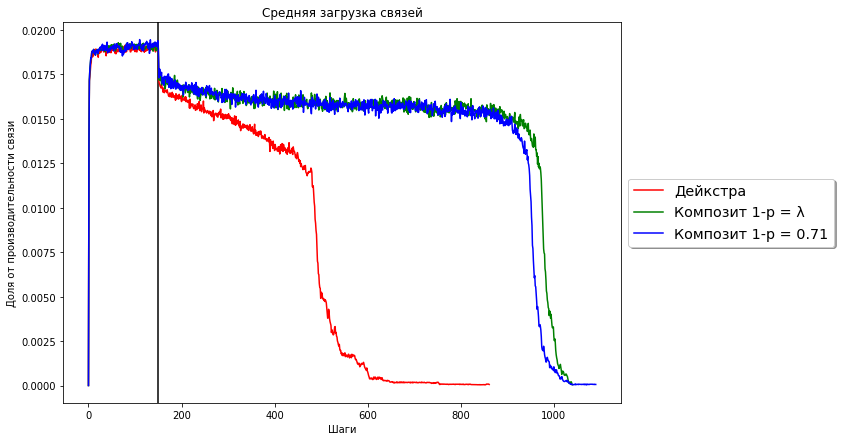

Доставлено 150001 Потеряно 0.0000% -Дейкстра
Доставлено 150000 Потеряно 0.0007% -Композит 1-p = λ
Доставлено 150000 Потеряно 0.0007% -Композит 1-p = 0.71


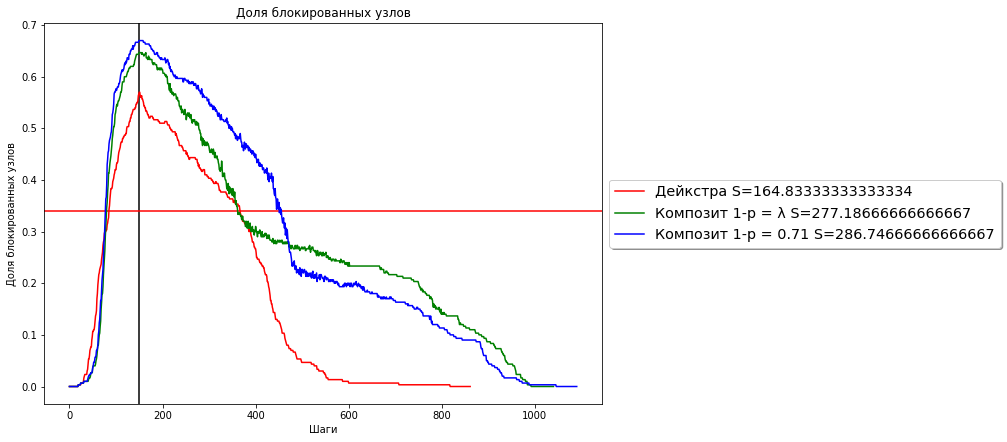

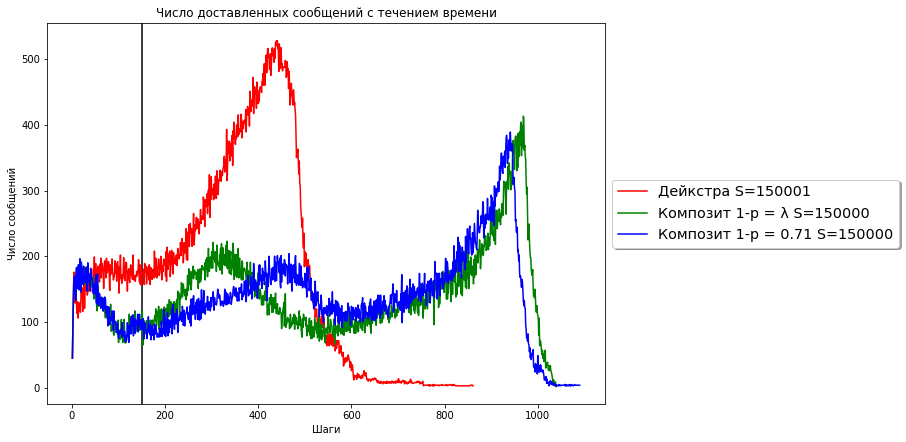

In [4]:
log_tags = [
 {"tag":  "9a259913-8ef1-487b-80e2-4da6c9bb65a1", "label": "Дейкстра", "color": "red"},
 #{"tag":  "1155413f-6d21-499d-90b3-3e01b5de6bb3", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "c242ad25-cc7e-4251-8878-3115e5a4b358", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b75380eb-bd64-4477-8a38-a86d227f2d79", "label": "Композит 1-p = 0.71", "color": "blue"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

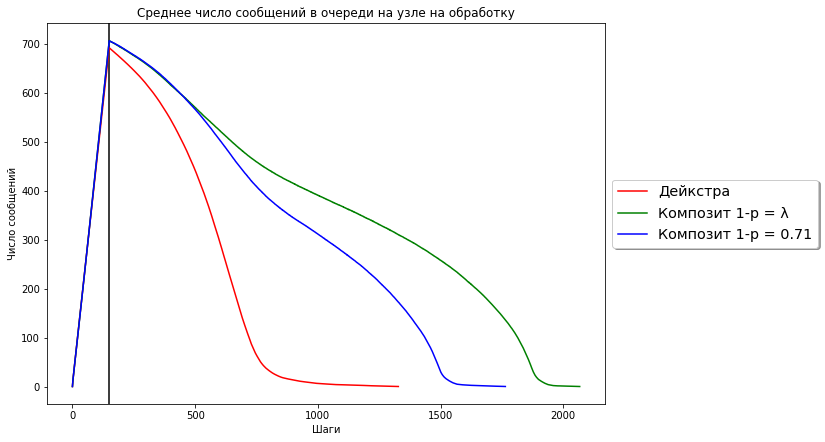

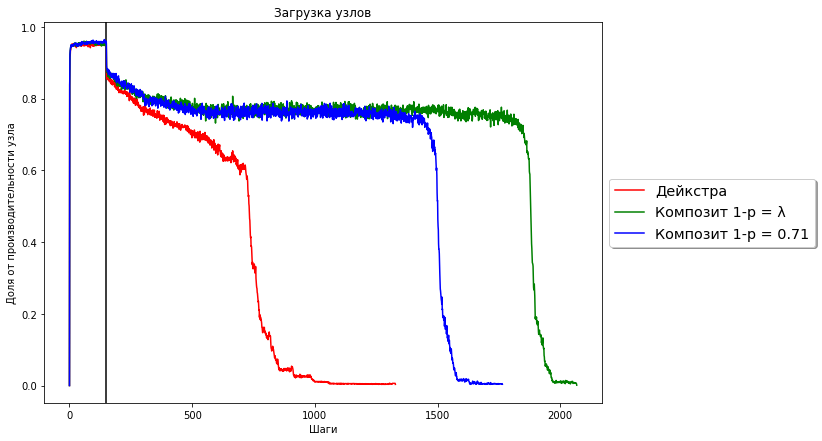

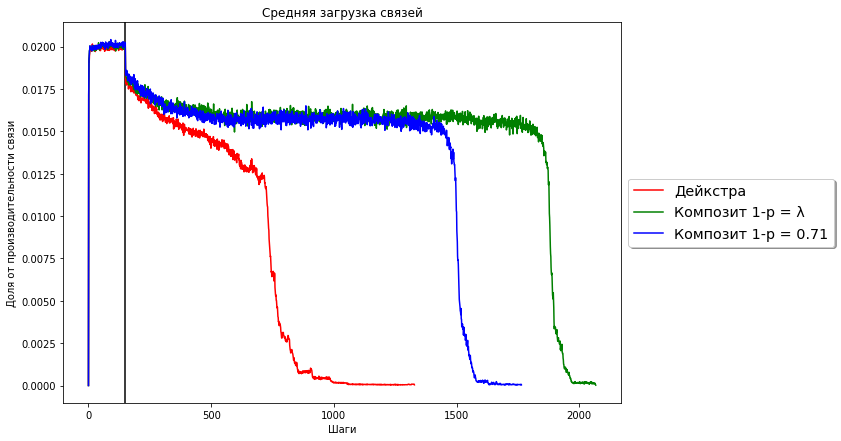

Доставлено 225001 Потеряно 0.0000% -Дейкстра
Доставлено 225000 Потеряно 0.0004% -Композит 1-p = λ
Доставлено 225000 Потеряно 0.0004% -Композит 1-p = 0.71


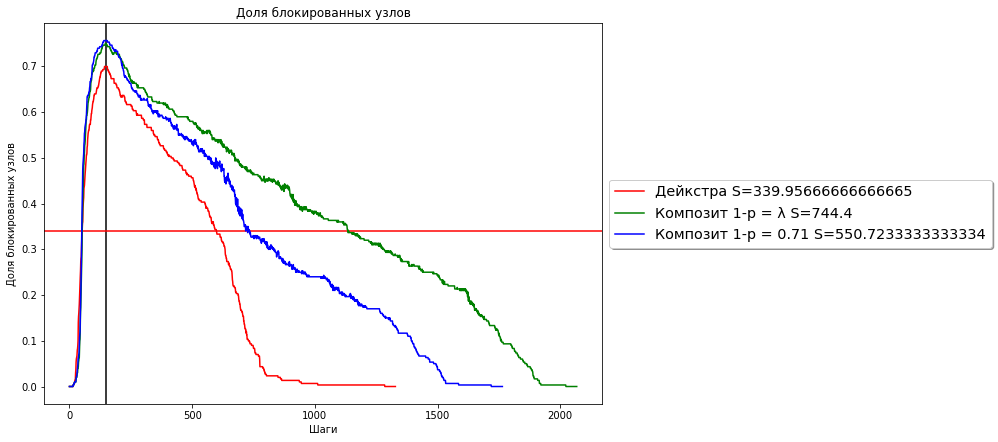

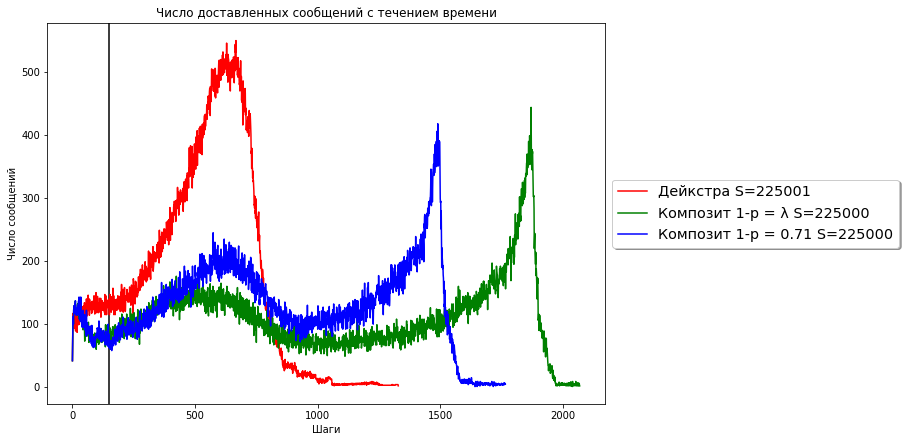

In [5]:
log_tags = [
 {"tag":  "47e3d02f-ac9c-4622-8efa-b87c4f625e13", "label": "Дейкстра", "color": "red"},
 #{"tag":  "4a376c54-9280-41b7-9d71-0bb8653f7014", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "237847ef-af3f-4f8a-9221-a3779ec7e600", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "a5e875e1-2128-4d5e-9e3c-65ce578301d8", "label": "Композит 1-p = 0.71", "color": "blue"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 45001 Потеряно 0.0000% -Дейкстра
Доставлено 45000 Потеряно 0.0022% -Композит 1-p = λ
Доставлено 45000 Потеряно 0.0022% -Композит 1-p = 0.71


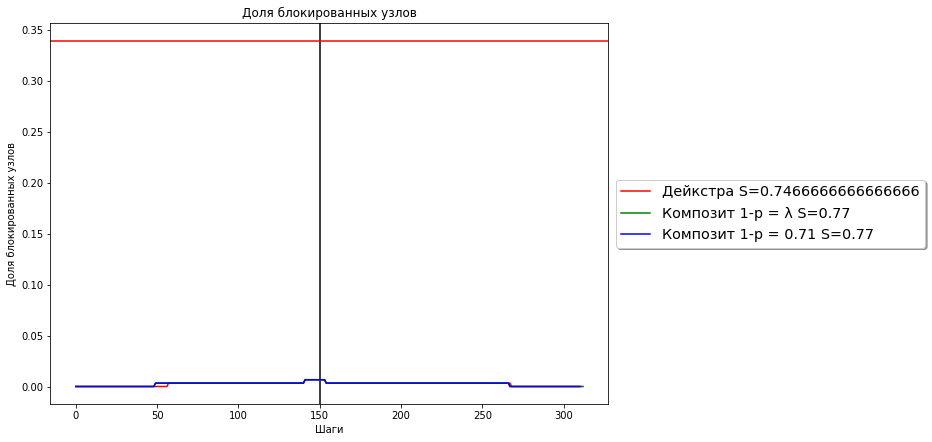

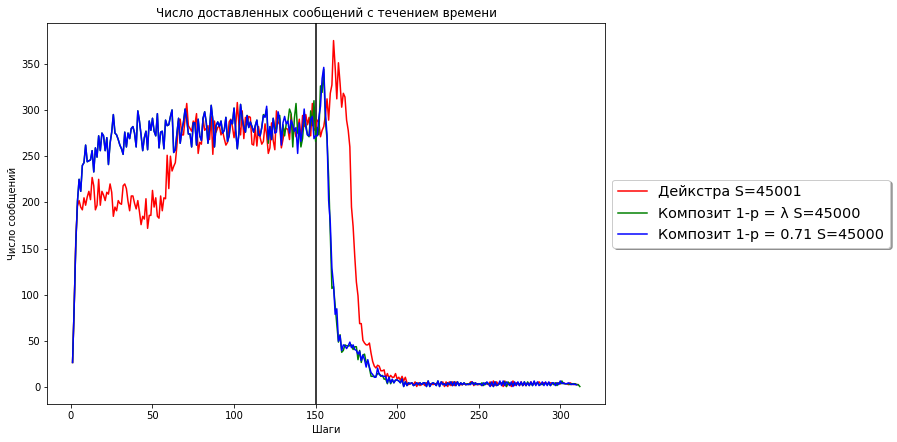

Доставлено 105001 Потеряно 0.0000% -Дейкстра
Доставлено 105000 Потеряно 0.0010% -Композит 1-p = λ
Доставлено 105000 Потеряно 0.0010% -Композит 1-p = 0.71


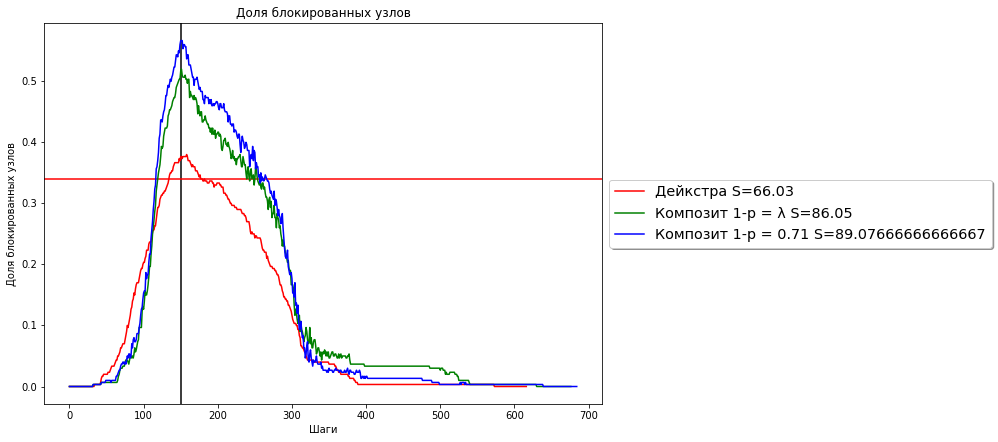

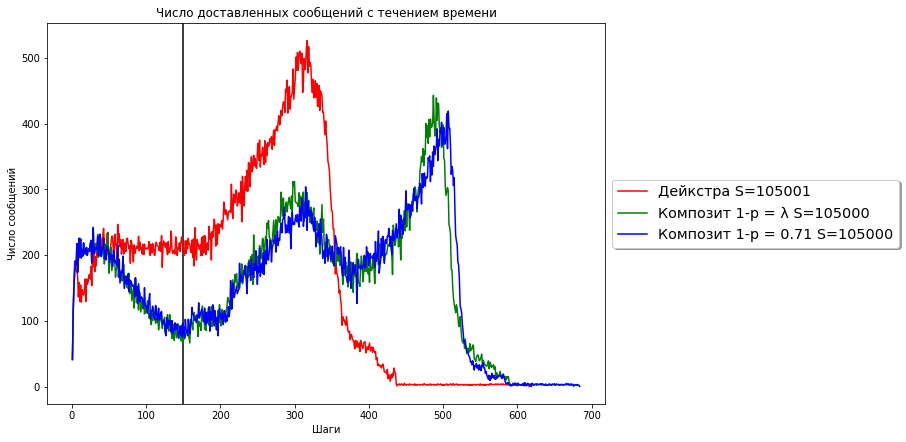

Доставлено 135001 Потеряно 0.0000% -Дейкстра
Доставлено 135000 Потеряно 0.0007% -Композит 1-p = λ
Доставлено 135000 Потеряно 0.0007% -Композит 1-p = 0.71


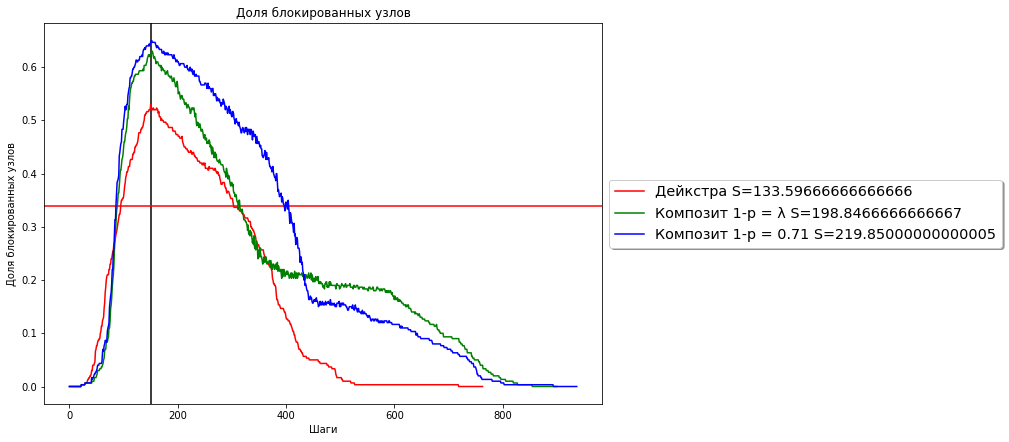

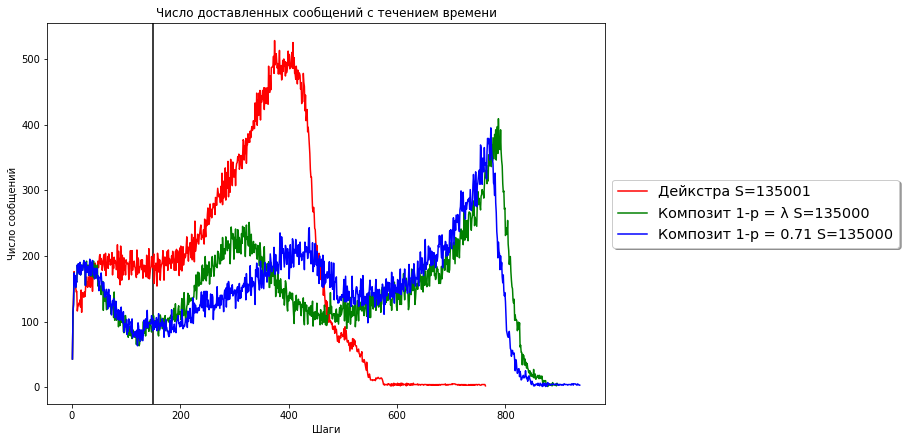

Доставлено 180001 Потеряно 0.0000% -Дейкстра
Доставлено 180000 Потеряно 0.0006% -Композит 1-p = λ
Доставлено 180000 Потеряно 0.0006% -Композит 1-p = 0.71


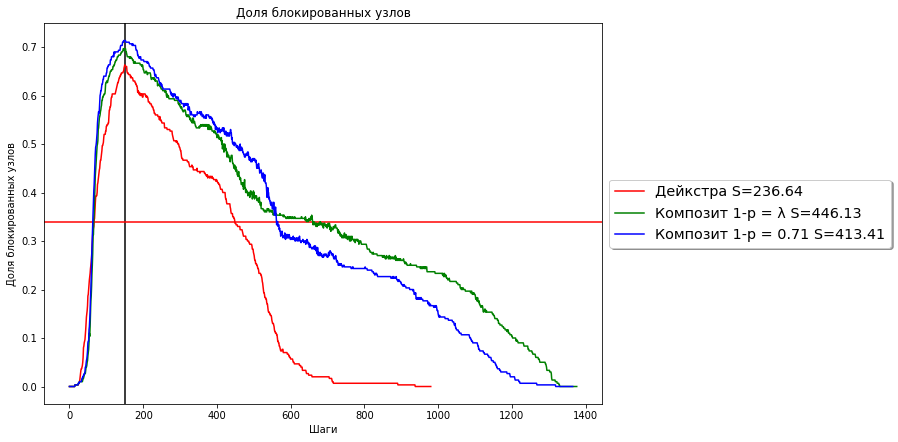

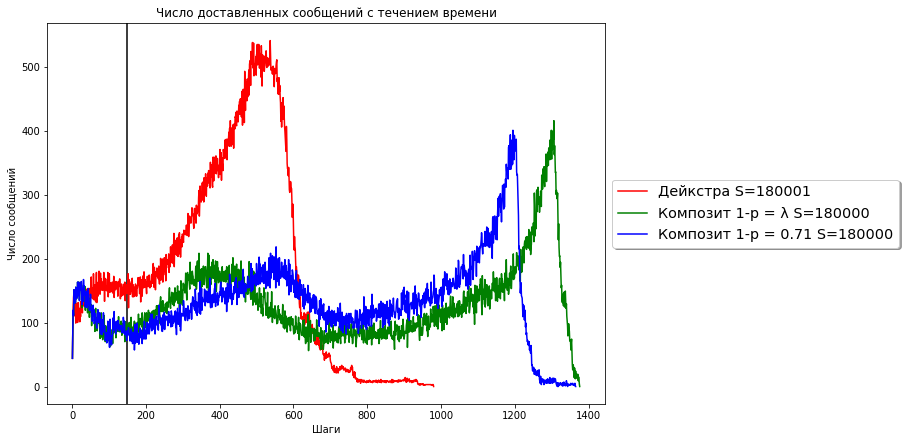

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "eaa90d2c-4fc3-4a0e-b8a3-f1c3285b1c9b", "label": "Дейкстра", "color": "red"},
 {"tag":  "89c20fe0-85d1-4153-905d-02c883890dd2", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "6a018a05-8c47-4023-be18-5b0dd3f1ae03", "label": "Композит 1-p = 0.71", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "2424b828-2dd6-46c8-bffb-48a3b82c685c", "label": "Дейкстра", "color": "red"},
 {"tag":  "1dff1384-d074-4add-8043-f48e2328e22e", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "0fed8811-44d8-4f04-aade-39bf58250e53", "label": "Композит 1-p = 0.71", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "64402eab-da33-447e-b35a-188185ee4d74", "label": "Дейкстра", "color": "red"},
 {"tag":  "04deabfc-bb4f-44a3-917b-3ecc545e4d11", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "f4c97389-3b81-4b08-9787-998f49fd664b", "label": "Композит 1-p = 0.71", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1200;  
log_tags = [
 {"tag":  "35ab3e20-f900-4a66-9c13-a7393a953a01", "label": "Дейкстра", "color": "red"},
 {"tag":  "aaf6e77b-8adb-4887-8796-c278b84cdb6e", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "cde71b94-ee4e-4ba3-aa4f-4a7a9059e923", "label": "Композит 1-p = 0.71", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

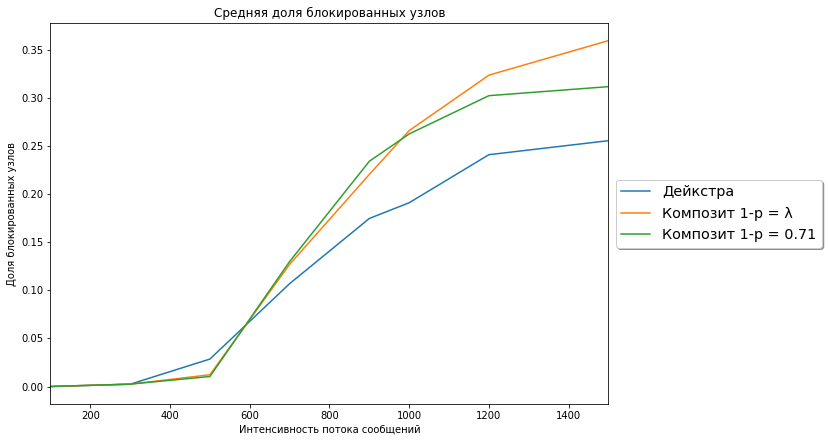

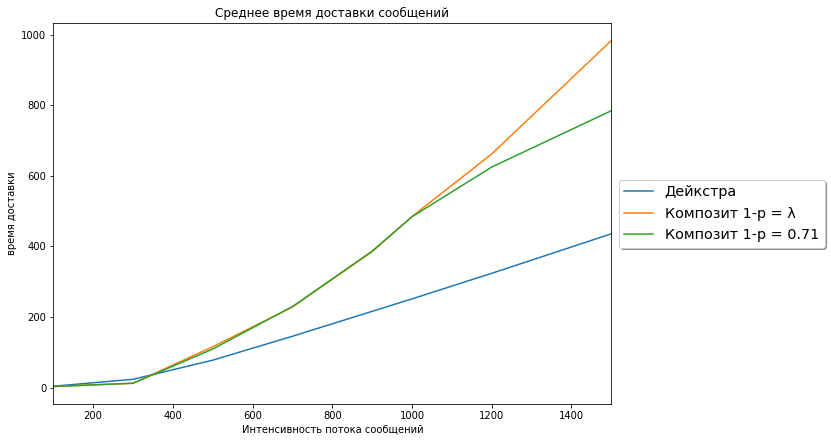

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.125136
Композит 1-p = λ       0.164089
Композит 1-p = 0.71    0.156849

Дейкстра               0.000000
Композит 1-p = λ       0.001698
Композит 1-p = 0.71    0.001698

Дейкстра               184.604289
Композит 1-p = λ       359.243452
Композит 1-p = 0.71    329.219153
